## Before you start working on the exercise

- Use Python version 3.7 up to 3.9. Make sure not to use Python 3.10
- It is highly recommended to create a virtual environment for this course. You can find resources on how to create a virtual environment on the ISIS page of the course.
- Make sure that no assertions fail or exceptions occur, otherwise points will be subtracted.
- Use all the variables given to a function unless explicitly stated otherwise. If you are not using a variable you are doing something wrong.
- Read the **whole** task description before starting with your solution.
- After you submit the notebook more tests will be run on your code. The fact that no assertions fail on your computer locally does not guarantee that you completed the exercise correctly.
- Please submit only the notebook file with its original name. If you do not submit an `ipynb` file you will fail the exercise.
- Edit only between YOUR CODE HERE and END YOUR CODE.
- Verify that no syntax errors are present in the file.
- Before uploading your submission, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel\Restart) and then run all cells (in the menubar, select Cell\Run All).

In [1]:
import sys

if (3,7) <= sys.version_info[:2] <= (3, 9):
    print("Correct Python version")
else:
    print(f"You are using a wrong version of Python: {'.'.join(map(str,sys.version_info[:3]))}")

Correct Python version


# Exercise Sheet 2: Timing, Numpy, Plotting

The previous exercise sheet introduced several methods for classification: decision trees, nearest neighbors, and nearest means. Of those, the one that could learn from the data, and that also offered enough complexity to produce an accurate decision function was k-nearest neighbors. However, nearest neighbors can be slow when implemented in pure Python (i.e. with loops). This is especially the case when the number of data points or input dimensions is large.

In this exercise sheet, we will speed up nearest neighbors by utilizing `numpy`, `scipy` and `scikit-learn` (sklearn) packages. Your task will be to **replace list-based operations by vector-based operations** between numpy arrays. The speed and correctness of the implementations will then be tested. In particular, performance graphs will be drawn using the library `matplotlib`.

Make sure to have installed all the required packages (numpy, scipy, sklearn). For this you can use `conda install <package>` or `pip install <package>`.

e.g. (-U will upgrade the package version if already installed)

`pip install -U numpy scipy scikit-learn matplotlib`

In [2]:
try:
    import numpy
    import scipy
    import sklearn
    import matplotlib
except ImportError:
    print("Please install NumPy, SciPy, scikit-learn and matplotlib using the instructions above.")
else:
    numpy_version = tuple(map(int, numpy.__version__.split(".")))
    scipy_version = tuple(map(int, scipy.__version__.split(".")))
    sklearn_version = tuple(map(int, sklearn.__version__.split(".")))
    matplotlib_version = tuple(map(int, matplotlib.__version__.split('.')))
    if numpy_version >= (1, 18, 0):
        print(f"NumPy version ok! {numpy_version}")
    else:
        print(f"Your NumPy version is too old!!! {numpy_version}")

    if scipy_version >= (1, 6, 0):
        print(f"SciPy version ok! {scipy_version}")
    else:
        print(f"Your SciPy version is too old!!! {scipy_version}")

    if sklearn_version >= (1, 0, 0):
        print(f"sklearn version ok! {sklearn_version}")
    else:
        print(f"Your sklearn version is too old!!! {sklearn_version}")

    if matplotlib_version >= (3,4,0):
        print(f'matplotlib version ok! {matplotlib_version}')
    else:
        print(f"Your matplotlib version is too old!!! {sklearn_version}")


    

NumPy version ok! (1, 23, 5)
SciPy version ok! (1, 9, 3)
sklearn version ok! (1, 2, 0)
matplotlib version ok! (3, 6, 2)


In [3]:
# This cell is for grading. DO NOT remove it

# Use unittest asserts
import unittest

t = unittest.TestCase()
from pprint import pprint
from minified import max_allowed_loops, no_imports, no_loops_allowed


# These are the type aliases that we define so that do not repeat outselves 
# in every function definition. You can look in the types.py file to see 
# the precise type definitions
from type_aliases import Dataset, Label, LabelList, DistanceCallable, Vector, NearestCallable


# Warm Ups

Before starting the homework sheet we recommend you finish these warm-up tasks. They won't get you any points but should help you get familiar with Numpy.

In [4]:
import numpy as np

np.random.seed(0)  # seed for reproducibility 

x1 = np.random.randint(10, size=6)  # random one-dimensional integer array of size 6 with values in [0, 10)
x2 = np.random.randint(10, size=(5, 4))  # random two-dimensional integer array

In [26]:
x1, x2

(array([5, 0, 3, 3, 7, 9]),
 array([[3, 5, 2, 4],
        [7, 6, 8, 8],
        [1, 6, 7, 7],
        [8, 1, 5, 9],
        [8, 9, 4, 3]]))

In [31]:
x2_rows_2_to_4_columns_0_to_3 = x2[2:5, 0:4] # rows 2 to 4, columns 0 to 3
x2_rows_2_to_4_columns_0_to_3

array([[1, 6, 7, 7],
       [8, 1, 5, 9],
       [8, 9, 4, 3]])

### Shape of an Array (0 P)

Write a function that returns the number of rows and the number of columns of an array.

* Use the attribute `.shape` that every numpy array has.

In [21]:
def array_shape(array):
    # YOUR CODE HERE
    no_of_dim = array.ndim
    if no_of_dim == 1:
        number_of_rows = array.shape[0]
        number_of_columns = 0  
    elif no_of_dim >= 2:
        number_of_rows = array.shape[0]
        number_of_columns = array.shape[1]
    # YOUR CODE HERE
    
    return number_of_rows, number_of_columns

In [22]:
# Test array_shape function
x1_number_of_rows, x1_number_of_columns = array_shape(x1)
x2_number_of_rows, x2_number_of_columns = array_shape(x2)

t.assertEqual(x1_number_of_rows, 6)
t.assertEqual(x1_number_of_columns, 0)
t.assertEqual(x2_number_of_rows, 5)
t.assertEqual(x2_number_of_columns, 4)

### Indexing (0 P)

Return subarrays of the given arrays according to the conditions. Use array indexing e.g. `x1[1:5:-2]` instead of  loops or hardcoding the solutions.

* Save the second to last element of `x1` in the variable `x1_second_to_last`.
* Save a subarray that has every other element of `x1` in the variable `x1_every_other_element`.
* Save a reversed `x1` in the variable `x1_reversed`.
* Save the element in row 3 and column 2 of `x2` in the variable `x2_element_in_row_3_and_column_2`. Please note that since indexing starts at zero so row 3 is actually the forth row.
* Save a subarray/matrix that contains rows 2 to 4 and columns 0 to 3 of `x2` in the variable `x2_rows_2_to_4_columns_0_to_3`. In this case row 4 and column 3 should be INCLUDED.

Try **not** to use the shape or length of an array for this exercise

In [34]:
# YOUR CODE HERE
x1_second_to_last = x1[4:5]
x1_every_other_element = x1[::2]
x1_reversed = x1[::-1]
x2_element_in_row_3_and_column_2 = x2[3,2]    # row 3, column 2
x2_rows_2_to_4_columns_0_to_3 = x2[2:5, 0:4] # rows 2 to 4, columns 0 to 3
# YOUR CODE HERE


In [35]:
# Test indexing solutions
t.assertEqual(x1_second_to_last, 7)
np.testing.assert_allclose(x1_every_other_element, np.array((5, 3, 7)))
np.testing.assert_allclose(x1_reversed, np.array((9, 7, 3, 3, 0, 5)))
t.assertEqual(x2_element_in_row_3_and_column_2, 5)
np.testing.assert_allclose(
    x2_rows_2_to_4_columns_0_to_3, np.array(((1, 6, 7, 7), (8, 1, 5, 9), (8, 9, 4, 3)))
)

### Broadcasting (0 P)

Understanding broadcasting is an important part of understanding numpy.

* Using `np.newaxis`, turn `array_a` into a column-vector and save the result in the variable `array_a_to_column_vector`.
* Add the one-dimensional `array_a` and the two dimensional `array_b` together. Do not use any function and only the `+` operator.
* Add the one-dimensional `array_a` and the two dimensional `array_c` together. Now it is important to use broadcasting since the dimensions of the two arrays do not match: `array_a.shape = (3,)` and `array_c.shape = (3,2).` Addition would work if the shape of `array_a` would be `(3,1)`.

In [36]:
array_a = np.ones(3)
array_b = np.arange(6).reshape((2, 3))
array_c = np.arange(6).reshape((3, 2))

In [37]:
array_a, array_b, array_c

(array([1., 1., 1.]),
 array([[0, 1, 2],
        [3, 4, 5]]),
 array([[0, 1],
        [2, 3],
        [4, 5]]))

In [43]:
# YOUR CODE HERE
array_a_to_column_vector = array_a[:, np.newaxis] # column vector
array_a_plus_array_b = array_a + array_b
array_a_plus_array_c = array_a_to_column_vector + array_c
# YOUR CODE HERE


In [44]:
# Test broadcasting solutions
np.testing.assert_allclose(array_a_to_column_vector, np.ones(3).reshape(3, 1))
np.testing.assert_allclose(array_a_plus_array_b, np.array(((1, 2, 3), (4, 5, 6))))
np.testing.assert_allclose(array_a_plus_array_c, np.array(((1, 2), (3, 4), (5, 6))))

## Python Nearest Neighbor

The most basic element of computation of nearest neighbors is its distance function relating two arbitrary data points `x1` and `x2`. We assume that these points are iterable (i.e. we can use a loop over their dimensions). One way among others to compute the **square** Euclidean distance between two points is by computing the sum of the component-wise distances.

In [45]:
def pydistance(x1: Vector, x2: Vector) -> float:
    """
    Calculates the square euclidean distance between two data points x1, x2

    Args:
        x1, x2: Two vectors (ndim=1) for which we want to calculate the distance
            `len(x1) == len(x2)` will always be True

    Returns:
        float: The square eucleadian distance between the two vectors
    """
    assert len(x1) == len(x2)
    return sum([(x1d - x2d) ** 2 for x1d, x2d in zip(x1, x2)])

In [46]:
x1, x2 = [1, 4, 3, 2], [4, 8, -2, 2]
print(f"pydistance({x1}, {x1}) --> {pydistance(x1, x1)}")
print(f"pydistance({x1}, {x2}) --> {pydistance(x1, x2)}")

pydistance([1, 4, 3, 2], [1, 4, 3, 2]) --> 0
pydistance([1, 4, 3, 2], [4, 8, -2, 2]) --> 50


where we use the prefix "`py-`" of the function to indicate that the latter makes use of pure `Python` instead of `numpy`. Once the distance matrix has been implemented, the nearest neighbor for a given unlabeled point `u` that we would like to classify is obtained by iterating over all points in the training set `(X, Y)`, selecting the point with smallest distance to `u`, and returning its corresponding label. Here `X` denotes the list of inputs in the training set and `Y` denotes the list of labels.

In [47]:
def pynearest(
    u: Vector, X: Dataset, Y: LabelList, distance: DistanceCallable = pydistance
) -> Label:
    """
    Applies the nearest neighbour to the input `u`
    with training set `X` and labels `Y`. The
    distance metric can be specified using the
    `distance` argument.

    Args:
        u: The input vector for which we want a prediction
        X: A 2 dimensional list containing the trainnig set
        Y: A list containing the labels for each vector in the training set
        distance: The distance metric. By default the `pydistance` function

    Returns:
        int: The label of the closest datapoint to u in X
    """
    _, closest_point_label = min(zip(X, Y), key=lambda xy: distance(u, xy[0]))
    return closest_point_label

Note that this function either uses function `pydistance` (given as default if the argument distance is not specified). Or one could specify as argument a more optimized function for distance compuation, for example, one that uses `numpy`. Finally, one might not be interested in classifying a single point, but many of them. The method below receives a collection of such unlabeled test points stored in the variable `U`. The function returns a list of predictions associated to each test point.

In [48]:
def pybatch(
    U: Dataset,
    X: Dataset,
    Y: LabelList,
    nearest: NearestCallable = pynearest,
    distance: DistanceCallable = pydistance,
) -> LabelList:
    """
    Applies the nearest neighbor algorithm, to all the datapoints
    `u` $\in$ `U`, with `X` the training set and `Y` the labels.
    Both the distance metric and the method of finding the
    neearest neighbor can be specified.

    Args:
        U: List of vectors for which a prediction is desired.
        X: A 2 dimensional list containing the trainnig set
        Y: A list containing the labels for each vector in the training set
        nearest: The method by which the nearest neighbor search happens.
        distance: The distance metric. By default the `pydistance` function

    Returns:
        A list of predicted labels for each `u` $\in$ `U`
    """
    return [nearest(u, X, Y, distance=distance) for u in U]

Again, such function uses by default the Python nearest neighbor search (with a specified distance function). However, we can also specified a more optimized nearest neighbor function, for example, based on `numpy`. Finally, one could consider an alternative function to `pybatch` that would use `numpy` from the beginning to the end. The implementation of such more optimized functions, and the testing of their correct behavior and higher performance will be the objective of this exercise sheet.

## Testing and correctness

As a starting point, the code below tests the output of the nearest neighbor algorithm for some toy dataset with fixed parameters. In particular, the function `data.toy(M,N,d)` generates a problem with `M` unlabeled test points stored in a matrix `U` of size `(M x d)`, then `N` labeled training points stored in a matrix `X` of size `(N x d)` and the output label is stored in a vector `Y` of size `N` composed of zeros and ones encoding the two possible classes. The variable `d` denotes the number of dimensions of each point. The toy dataset is pseudo-random, that is, for fixed parameters, it produce a random-looking dataset, but every time the method is called with the same parameters, the dataset is the same. The pseudo-randomness property will be useful to verify that each nearest neighbor implementation performs the same overall computation. Please check the `data.py` file within the exercise folder for the implementation details. 

In [49]:
import os

if "data.py" not in os.listdir():
    t.fail("Did you download the 'data.py' file from ISIS?")


import data

U, X, Y = data.toy(20, 100, 50)               # 20 unlabeled datapoints, 100 training points, 50 labels

print(f"Shape of U (unlabeled datapoints): {U.shape}")
print(f"Shape of X (training set): {X.shape}")
print(f"Shape of Y (labels): {Y.shape}")
print(f"Predictions: {pybatch(U, X, Y)}")

Shape of U (unlabeled datapoints): (20, 50)
Shape of X (training set): (100, 50)
Shape of Y (labels): (100,)
Predictions: [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


In particular, the output of this function will help us to verify that the more optimized `numpy`-based versions of nearest neighbor are still valid.

## Plotting and performance

We now describe how to build a plot that relates a certain parameter of the dataset (e.g. the number of input dimensions `d` to the time required for the computation. We first initialize the basic plotting environment.

In [50]:
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline                      # This is a Jupyter notebook specific command to display plots inline in the notebook itself (not in a separate window)

The command "`%matplotlib inline`" tells IPython notebook that the plots should be rendered inside the notebook. 

The following code plots the computation time of predicting `100` points from the test set using a training set of size `100`, and where we vary the number of input dimensions. The measurement of time happens with the `timeit` module. `timeit` provides many convinience functions for benchmarking. In particular the repeat function runs the provided code many times and returns the time it took to run it. You can find more information about `repeat` [here](https://docs.python.org/3/library/timeit.html#timeit.repeat)

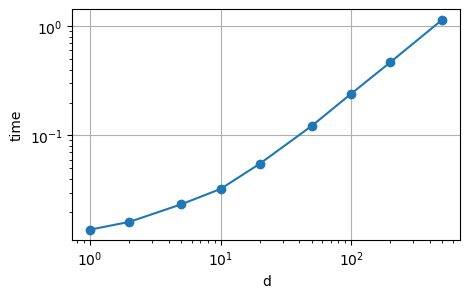

In [51]:
import timeit
from statistics import mean

# Values for the number of dimensions d to test
dlist = [1, 2, 5, 10, 20, 50, 100, 200, 500]

# Measure the computation time for each choice of number of dimensions d
tlist = []
for d in dlist:
    U, X, Y = data.toy(100, 100, d)
    # get the average of three runs
    delta = mean(timeit.repeat(lambda: pybatch(U, X, Y), number=1, repeat=3))   # timeit.repeat returns a list of times, so we take the mean of those times to get the average
    tlist.append(delta)

# Plot the results in a graph
fig = plt.figure(figsize=(5, 3))
plt.plot(dlist, tlist, "-o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("d")
plt.ylabel("time")
plt.grid(True)

The time on the vertical axis is in seconds. Note that the exact computation time depends on the speed of your computer. As expected, the computation time increases with the number of input dimensions. Unfortunately, for the small dataset considered here (`100` training and test points of `100` dimensions each), the algorithm already takes more than one second to execute. Thus, it is necessary for practical applications (e.g. the digit recognition task that we will consider at the end of this exercise sheet) to accelerate this nearest neighbor algorithm.

## 1. Accelerating the distance computation (25 P)

In this first exercise, we would like to accelerate the function that compute pairwise distances.

**a)** Implement the function `npdistance(x1,x2)` with the same output as `pydistance(x1,x2)`, but that computes the squared Euclidean distance using `numpy` operations. Verify that in both cases (i.e. using either `npdistance` or `pydistance` in the function `pybatch`) the output for the above toy example with parameters `M=20`, `N=100`, `d=50` (i.e. `data.toy(20,100,50)`) remains the same.

Our goal with this exercise is to speed-up our code. In practice this means that we want to remove for loops from our code. Therefore if your implementation contains a `for loop` it will automatically be considered wrong and will receive 0 points. Similarlly Python functions that hide for loops such as `map` are also considered invalid for this exercise. Similarly, functions provided by numpy that hide for loops like [`vectorize`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html) and [`apply_along_axis`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.apply_along_axis.html) are also **not** to be used. Further the builtin function `sum` is not allowed to be used, however `np.sum` can be used.

**Note**: The input vectors can be either `np.ndarray` or lists of `floats`.

In [52]:
import numpy as np

In [83]:
@no_loops_allowed
@no_imports
def npdistance(x1: Vector, x2: Vector) -> float:
    """
    Calculates the square euclidean distance between two data points x1, x2
    using `numpy` vectorized operations

    Args:
        x1, x2: Two vectors (ndim=1) for which we want to calculate the distance
        `len(x1) == len(x2)` will always be True

    Returns:
        float: The distance between the two vectors x1, x2
    """
    # YOUR CODE HERE
    x1 = np.array(x1)
    x2 = np.array(x2)
    dist = np.linalg.norm(x1 - x2) ** 2
    return float(dist)
    # YOUR CODE HERE
    

In [84]:
# Verify your function
x1, x2 = [0.0, -1.0, -2.0], [2.0, 3.0, 4.0]

dist_to_same = npdistance(x1, x1)
print(f"npdistance({x1}, {x1}) --> {dist_to_same}\n")
expected_dist_to_same = 0.0
t.assertAlmostEqual(
    dist_to_same,
    expected_dist_to_same,
    msg="The distance of a vector to itself should be 0",
)


dist = npdistance(x1, x2)
print(f"npdistance({x1}, {x2}) --> {dist}")
expected_dist = pydistance(x1, x2)
print(f"expected_dist --> {expected_dist}\n")
t.assertAlmostEqual(dist, expected_dist)

U, X, Y = data.toy(20, 100, 50)

no_numpy = pybatch(U, X, Y, distance=pydistance)
print(f"no_numpy --> {no_numpy}")

w_np_dist = pybatch(U, X, Y, distance=npdistance)
print(f"w_np_dist  --> {w_np_dist}")

np.testing.assert_allclose(no_numpy, w_np_dist)

npdistance.assert_no_imports()
npdistance.assert_not_too_many_loops()

npdistance([0.0, -1.0, -2.0], [0.0, -1.0, -2.0]) --> 0.0

npdistance([0.0, -1.0, -2.0], [2.0, 3.0, 4.0]) --> 56.0
expected_dist --> 56.0

no_numpy --> [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
w_np_dist  --> [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


**b)** Create a plot similar to the one above, but where the computation time required by both methods are shown in a superposed manner. Here, we fix `M=100`, `N=100`, and we let `d` vary from `1` to `500`, taking the list of values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`. Your plot should show a quisi-constant runtime for the pybarch call using the `npdistance` function, compared to `pydistance`.

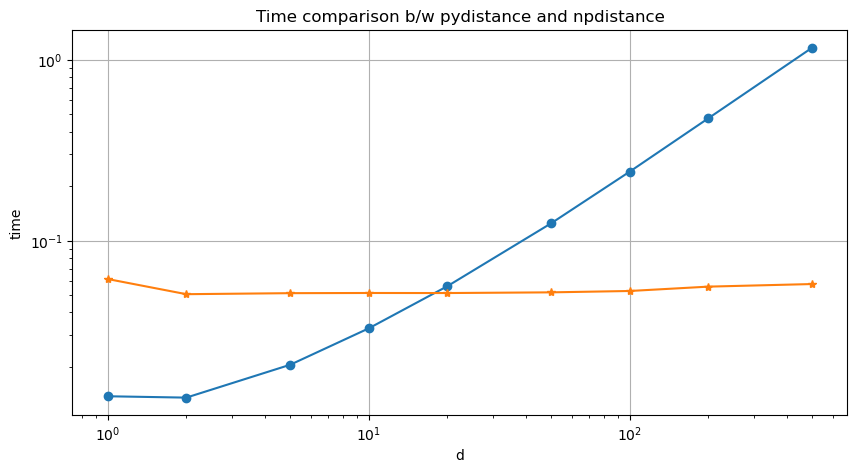

In [63]:
# YOUR CODE HERE
dlist = [1, 2, 5, 10, 20, 50, 100, 200, 500]

# Measure the computation time for each choice of number of dimensions d

tlist = []
new_list = []
for d in dlist:
    U, X, Y = data.toy(100, 100, d)
    # get the average of three runs
    delta = mean(timeit.repeat(lambda: pybatch(U, X, Y, distance=pydistance), number=1, repeat=3))
    beta = mean(timeit.repeat(lambda: pybatch(U, X, Y, distance=npdistance), number=1, repeat=3))
    tlist.append(delta)
    new_list.append(beta)


fig = plt.figure(figsize=(10, 5))
plt.plot(dlist, tlist, "-o",label="pydistance")
plt.plot(dlist, new_list, "-*", label="npdistance")
plt.xscale("log")
plt.yscale("log")
plt.title("Time comparison b/w pydistance and npdistance")
plt.xlabel("d")
plt.ylabel("time")
plt.grid(True)
# YOUR CODE HERE


## 2. Accelerating the nearest neighbor search (25 P)

Motivated by the success of the `numpy` optimized distance computation, we would like further accelerate the code by performing nearest neighbor search directly in `numpy`.

**a)** Implement the function `npnearest(u,X,Y)` as an alternative to the function `pynearest(u,X,Y,distance=npdistance)` that we have used in the previous exercise. Again, verify your function for the same toy example as before (i.e. `data.toy(20,100,50)`).

Unlike `pynearest`, `npnearest` doesn't receive any distance argument. `npnearest` will work only with square eucledian distance. If you are confident that your `npdistance` implementation can work between a vector and a matrix, you are welcome to reuse it. It is however, perfectly acceptable to reimplement the distance algorithm in this function again.

Once again the use of `for loops`, or functions like `map` or `vectorize` is stictly not allowed in this exercise.

In [ ]:
from typing import Any

In [85]:
@no_loops_allowed
@no_imports
def npnearest(u: "Vector", X: "Dataset", Y: "LabelList", *args: "Any", **kwargs: "Any") -> int:
    """
    Finds x1 so that x1 is in X and u and x1 have a minimal distance (according to the
    provided distance function) compared to all other data points in X. Returns the label of x1

    Args:
        u: The vector (ndim=1) we want to classify
        X: A matrix (ndim=2) with training data points (vectors)
        Y: A vector containing the label of each data point in X
        args, kwargs  : Ignored. Only for compatibility with pybatch

    Returns:
        The label of the data point which is closest to `u`
    """
    # YOUR CODE HERE
    distance = np.sum(np.square(X-u),axis=1)        # distance between u and all the points in X & summing up the squares of the differences, axis=1 means summing up the rows
    min_index = np.argmin(distance)                 # finding the index of the minimum distance which is the index of the nearest point to u in X 
    return Y[min_index]                             # returning the label of the nearest point to u in X
    # YOUR CODE HERE
    

In [86]:
TINY_U, TINY_X, TINY_Y = data.toy(3, 3, 3)
tiny_u = TINY_U[0]
print("u")
pprint(tiny_u)
print("\nX")
pprint(TINY_X)
print("\nY")
pprint(TINY_Y)

np_nearest = npnearest(tiny_u, TINY_X, TINY_Y)
expected_nearest = pynearest(tiny_u, TINY_X, TINY_Y)
print(f"\nnp_nearest --> {np_nearest}")
print(f"expected_nearest --> {expected_nearest}")

t.assertEqual(expected_nearest, np_nearest)

# Verify your function
np.testing.assert_allclose(
    pybatch(U, X, Y, nearest=pynearest), pybatch(U, X, Y, nearest=npnearest)
)

npnearest.assert_no_imports()
npnearest.assert_not_too_many_loops()

u
array([0.69646919, 0.28613933, 0.22685145])

X
array([[0.24875591, 0.16306678, 0.78364326],
       [0.80852339, 0.62562843, 0.60411363],
       [0.8857019 , 0.75911747, 0.18110506]])

Y
array([1, 0, 0])

np_nearest --> 0
expected_nearest --> 0


In [ ]:
# This cell is for grading. DO NOT remove it

**b)** Create a plot similar to the one above, where the new method is compared to the previous one. This means that you should compare the runtime of `npnearest` and `pynearest` with `npdistance` as its distance function. Here, we fix `M=100`, `d=100`, and we let `N` take different values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`.

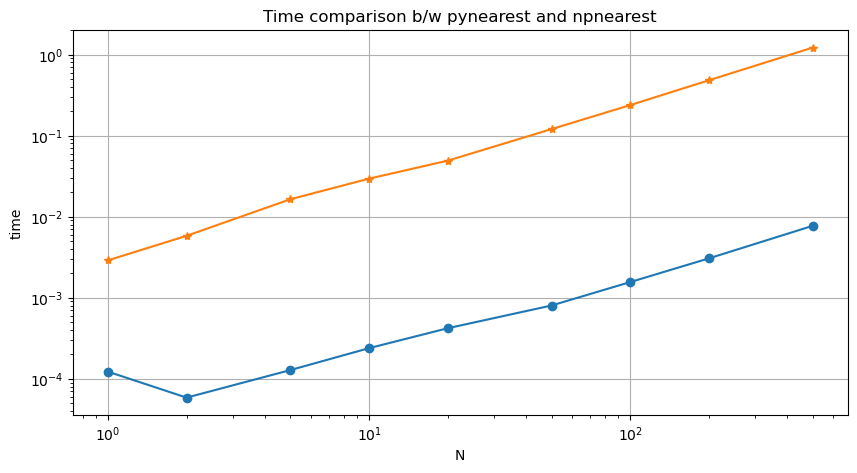

In [87]:
# YOUR CODE HERE
N = [1, 2, 5, 10, 20, 50, 100, 200, 500]

npnearest_time = []
pynearest_time = []

for n in N:
    U, X, Y = data.toy(n, 100, 100)
    npnearest_time.append(mean(timeit.repeat(lambda: pybatch(U, X, Y, nearest=npnearest), number=1, repeat=3)))   # get the average of three runs for npnearest and pynearest because we are using timeit.repeat
    pynearest_time.append(mean(timeit.repeat(lambda: pybatch(U, X, Y, nearest=pynearest), number=1, repeat=3)))

fig = plt.figure(figsize=(10, 5))
plt.plot(N, npnearest_time, "-o", label="npnearest")
plt.plot(N, pynearest_time, "-*", label="pynearest")
plt.xscale("log")
plt.yscale("log")
plt.title("Time comparison b/w pynearest and npnearest")
plt.xlabel("N")
plt.ylabel("time")
plt.grid(True)
# YOUR CODE HERE



## 3. Accelerating the processing of multiple test points (25 P)

Not yet fully happy with the performance of the algorithm, we would like to further optimize it by avoiding performing a loop on the test points, and instead, classify them all at once.

**a)** Implement the function `npbatch(U,X,Y)` as a replacement of the implementation `pybatch(U,X,Y,nearest=npnearest)` that we have built in the previous exercise. Inside this function, use [`scipy.spatial.distance.cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) for the actual distance computation. Again, verify your function for the same toy example as before (i.e. `data.toy(20,100,50)`).

In [92]:
import scipy

# for some systems we need to import spatial explicitly
from scipy.spatial import distance


@no_loops_allowed
@no_imports
def npbatch(U: "Dataset", X: 'Dataset', Y: 'LabelList', *args: 'Any', **kwargs: 'Any') -> np.ndarray:
    """
    This function has the same functionality as the `pybatch` function.
    HOWEVER, the distance function is fixed (scipy.spatial.distance.cdist).
    It does not use any of the functions defined by us previously.

    Args:
        U: A matrix (ndim=2) containing multiple vectors which we want to classify
        X: A matrix (ndim=2) that represents the training data
        Y: A vector (ndim=1) containing the labels for each data point in X

        All other arguments are ignored. *args, **kwargs are only there for compatibility
        with the `pybatch` function

    Returns:
        A vector (ndim=1) with the predicted label for each vector $u \in U$
    """
    # YOUR CODE HERE
    dist = distance.cdist(U, X, metric="euclidean") # calculating the distance between each point in U and X
    min_index = np.argmin(dist,axis=1)              # finding the index of the minimum distance which is the index of the nearest point to u in X
    return Y[min_index]                             # returning the label of the nearest point to u in X

    # YOUR CODE HERE
    

In [93]:
print("U")
pprint(TINY_U)
print("\nX")
pprint(TINY_X)
print("\nY")
pprint(TINY_Y)

expected_output = pybatch(TINY_U, TINY_X, TINY_Y)
print(f"\nexpected_output --> {expected_output}")
actual_output = npbatch(TINY_U, TINY_X, TINY_Y)
print(f"actual_output --> {actual_output}")
np.testing.assert_allclose(expected_output, actual_output)

U, X, Y = data.toy(20, 100, 50)
np.testing.assert_allclose(pybatch(U, X, Y), npbatch(U, X, Y))

npbatch.assert_no_imports()
npbatch.assert_not_too_many_loops()


U
array([[0.69646919, 0.28613933, 0.22685145],
       [0.55131477, 0.71946897, 0.42310646],
       [0.9807642 , 0.68482974, 0.4809319 ]])

X
array([[0.24875591, 0.16306678, 0.78364326],
       [0.80852339, 0.62562843, 0.60411363],
       [0.8857019 , 0.75911747, 0.18110506]])

Y
array([1, 0, 0])

expected_output --> [0, 0, 0]
actual_output --> [0 0 0]


In [ ]:
# This cell is for grading. DO NOT remove it

**b)** Create a plot comparing the computation time of the new implementation compared to the previous one. Here, we fix `N=100`, `d=100`, and we let `M` vary from `1` to `500` with values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`.

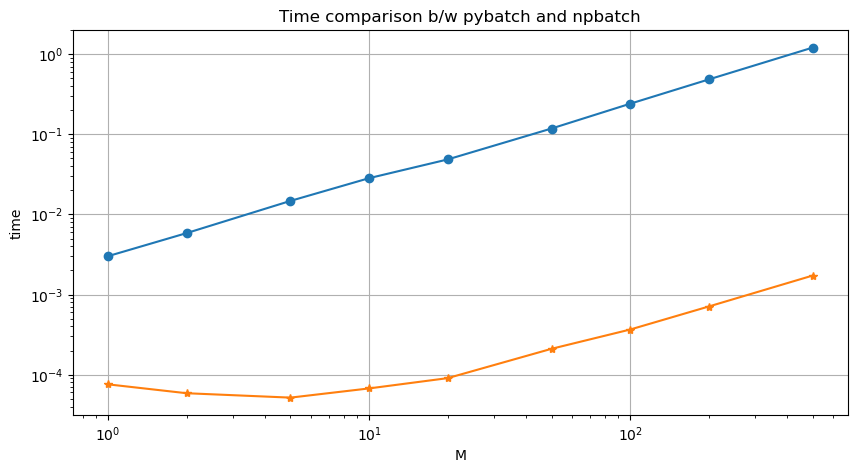

In [94]:
# YOUR CODE HERE
M = [1, 2, 5, 10, 20, 50, 100, 200, 500]

npbatch_time = []
pybatch_time = []

for m in M:
    U, X, Y = data.toy(100, m, 100)
    npbatch_time.append(mean(timeit.repeat(lambda: pybatch(U, X, Y), number=1, repeat=3)))
    pybatch_time.append(mean(timeit.repeat(lambda: npbatch(U, X, Y), number=1, repeat=3)))

fig = plt.figure(figsize=(10, 5))
plt.plot(M, npbatch_time, "-o", label="npbatch")
plt.plot(M, pybatch_time, "-*", label="pybatch")
plt.xscale("log")
plt.yscale("log")
plt.title("Time comparison b/w pybatch and npbatch")
plt.xlabel("M")
plt.ylabel("time")
plt.grid(True)
# YOUR CODE HERE


## 4. Application to real-world data (25 P)

Having now implemented an efficient K-nearest neighbor classifier, we can test it on real problems with many data points and dimensions. We consider a small handwritten digits recognition dataset, that can be directly obtained from the library `scikit-learn`. This dataset consists of handwritten digits of size `8 x 8` flattened into arrays of size `64`, with class between `0` and `9`. We use a function `data.digits()` to load the data and arrange data points in some predefined order.

In [95]:
X, Y = data.digits()
print(f"Shape of data: {X.shape}")
print(f"Shape of labels: {Y.shape}")

Shape of data: (1797, 64)
Shape of labels: (1797,)


**a) 10P** Using the function `imshow` of `matplotlib.pyplot (plt)` to visualize the first 16 digits (in a `4x4` grid) of the dataset. You get 8 points for a correct implementation and 2 points for an implementation that doesn't use any for loops.

**Hint**: Use the `np.traspose` and `np.reshape` functions, to implement the function without any loops.

**Note**: Your solution should output exactly one plot and shouldn't create new figures i.e. call `plt.show` or use `plt.figure` in a loop. The image will still be shown in the next cell, since we have configured matplotlib, to call plt.show, at the end of each cell.

In [96]:
@max_allowed_loops(1)  # but try to use 0
@no_imports
def plot_first_digits() -> None:
    """
    Loads the digit dataset and plots the first 16 digits in one image
    You are encouraged to implement this functions without
    the use of any for-loops. A solution that does not use loops
    calls plt.imshow once and does not use an unrolled loop.
    """
    # YOUR CODE HERE
    X, Y = data.digits()
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))                                              # creating a 4x4 grid of subplots to plot the first 16 digits in one image 
    plt.imshow(X[0:16].reshape(4, 4, 8, 8).swapaxes(1, 2).reshape(4 * 8, 4 * 8), cmap="gray")   # reshaping the first 16 digits to 4x4 grid and plotting them in one image using plt.imshow
    plt.axis("off")                                               # removing the axis from the image because we are plotting 16 digits in one image and the axis will be too small to see
    plt.show()                                                   # displaying the image
    
    # YOUR CODE HERE
    

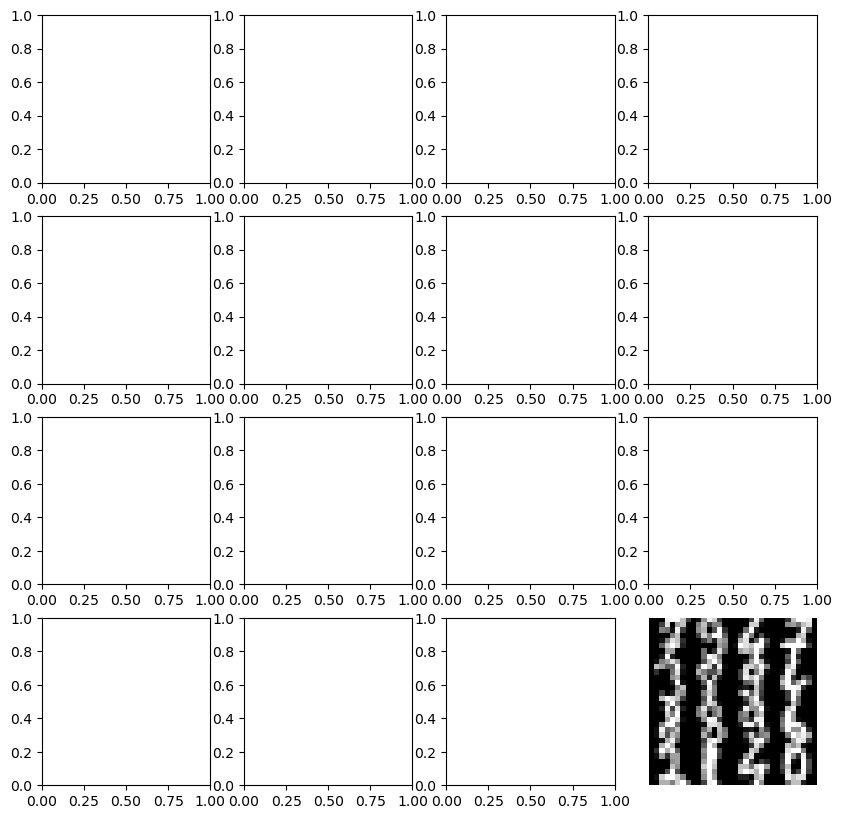

In [97]:
plot_first_digits()


**b)**
* Partition the data into a "training" set and "test" set. The training set contains the first 1000 digits of `X`, and the test set contains the remaining ones.

* Assume that you don't know the labels for the test data and classify the test data using your efficient nearest neighbor implementation.

* Print the predicted labels for the test set.

In [98]:
from typing import Tuple

In [105]:
def train_test_split(x: Dataset, y: LabelList) -> Tuple[Dataset, Dataset, LabelList, LabelList]:
    """
    Splits the data into train and test sets
    The first 1000 samples belong to the training set the rest to the test set

    Args:
        x: A matrix (ndim=2) containing the data
        y: A vector (ndim=1) containing the label for each datapoint

    Returns:
        A tuple containing 4 elements. The training data, the test data, the training labels
        and the test labels
    """
    # YOUR CODE HERE
    x_train = x[0:1000]     # training data
    x_test = x[1000:]       # test data
    y_train = y[0:1000]     # training labels
    y_test = y[1000:]       # test labels

    return x_train, x_test, y_train, y_test

    # YOUR CODE HERE
    


def predict(x_train: Dataset, x_test: Dataset, y_train: LabelList) -> LabelList:
    """
    For each x in x_test this function finds the nearest neighbour in x_train and
    returns that label

    This function is a wrapper of the `npbatch` function

    Args:
        x_train: A matrix (ndim=2) containing all the training data
        x_test: A matrix (ndim=2) containing all the test data for which we want a prediction
        y_train: A vector (ndim=1) containing the label of each datapoint in the training set

    Returns:
        A vector with the prediction for each datapoint/vector in x_test
    """
    # YOUR CODE HERE
    y_test_predict = [npnearest(x, x_train, y_train) for x in x_test]   # predicting the labels for each vector in x_test using npnearest function and storing them in a list y_test_predict
    # YOUR CODE HERE
    
    return y_test_predict

In [106]:
train_test_output = train_test_split(X, Y)
x_train, x_test, y_train, y_test = train_test_output

# check if types match
t.assertIsInstance(x_train, np.ndarray)
t.assertIsInstance(x_test, np.ndarray)
t.assertIsInstance(y_train, np.ndarray)
t.assertIsInstance(y_test, np.ndarray)

# check if shapes match
t.assertEqual(x_train.shape, (1000, 64))
t.assertEqual(x_test.shape, (797, 64))
t.assertEqual(y_train.shape, (1000,))
t.assertEqual(y_test.shape, (797,))

# check that first values match
t.assertEqual(y_train[0], 7)
t.assertEqual(y_test[0], 0)



In [ ]:
# This cell is for grading. DO NOT remove it

In [107]:
# check if prediction shape matches
predictions = predict(x_train, x_test, y_train)
t.assertEqual(predictions.shape, (797,))

first_three = predictions[:3]
print(f"first_three --> {first_three}")

expected_first_three = pybatch(x_test[:3], x_train, y_train)
print(f"expected_first_three --> {expected_first_three}")

np.testing.assert_allclose(first_three, expected_first_three)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# This cell is for grading. DO NOT remove it

**c)** 
* Finally, in order to determine the accuracy of the classifier, we would like to compare the predictions with the ground truth (i.e. the true labels from the test data).

* Compute the fraction of the test set where the predictions of the nearest neighbor algorithm and labels disagree. 

In [108]:
def evaluate(x_train: Dataset, x_test: Dataset, y_train: LabelList, y_test: LabelList) -> float:
    """
    Evaluates the accuracy of our nearest neighbor classifier
    by calculating the ratio of test samples for which
    our classification method disagrees with the ground truth

    Args:
        x_train: A matrix (ndim=2) containing the training data for the classifier
        x_test: A matrix (ndim=2) containing the test data for which the classifier
        will make a prediction
        y_train: The labels for the training data
        y_test: The labels for the test data
    Returns:
        float: The ratio in [0-1] of the test samples for which our
        nearest neighbor classifier disagrees with the provided labels
    """
    # YOUR CODE HERE
    y_test_predict = predict(x_train, x_test, y_train)   # predicting the labels for each vector in x_test using predict function and storing them in a list y_test_predict
    accuracy = np.sum(y_test_predict == y_test) / len(y_test)   # calculating the accuracy of the classifier by comparing the predicted labels with the actual labels
    return accuracy
    # YOUR CODE HERE
    

In [109]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
ratio_disagree = evaluate(x_train, x_test, y_train, y_test)
print(f"ratio_disagree --> {ratio_disagree}")

# make sure this is a percentage
t.assertGreaterEqual(ratio_disagree, 0.0, "A percentage cannot be less than 0")
t.assertLessEqual(ratio_disagree, 1.0, "A percentage cannot be more that 1")

# Upper bound for disagree ratio
t.assertLess(ratio_disagree, 0.01, "Your solution should return less than 0.01")
t.assertGreater(ratio_disagree, 0.008, "Your solution should return more that 0.008")

ratio_disagree --> 0.9912170639899623


AssertionError: 0.9912170639899623 not less than 0.01 : Your solution should return less than 0.01